# Tugas 1

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Upload file voice.csv ke Colab terlebih dahulu
# Membaca dataset
data = pd.read_csv('/content/drive/MyDrive/MachineLearning/voice.csv')
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


Jumlah data: (3168, 21)

Jumlah label tiap kelas:
label
male      1584
female    1584
Name: count, dtype: int64


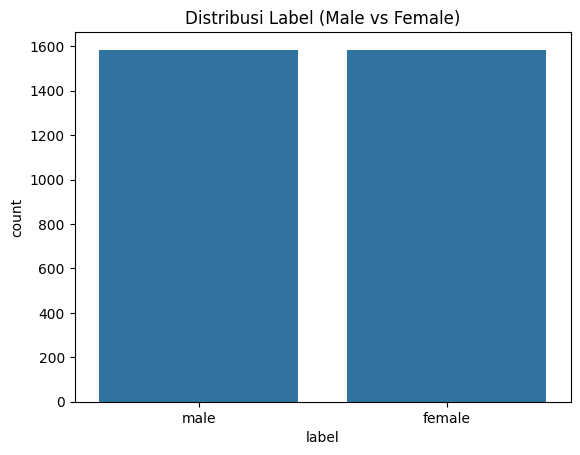

In [ ]:
print("Jumlah data:", data.shape)
print("\nJumlah label tiap kelas:")
print(data['label'].value_counts())

# Visualisasi distribusi label
sns.countplot(x='label', data=data)
plt.title('Distribusi Label (Male vs Female)')
plt.show()

In [ ]:
# Encode label
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

# Pisahkan fitur dan target
X = data.drop('label', axis=1)
y = data['label']

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

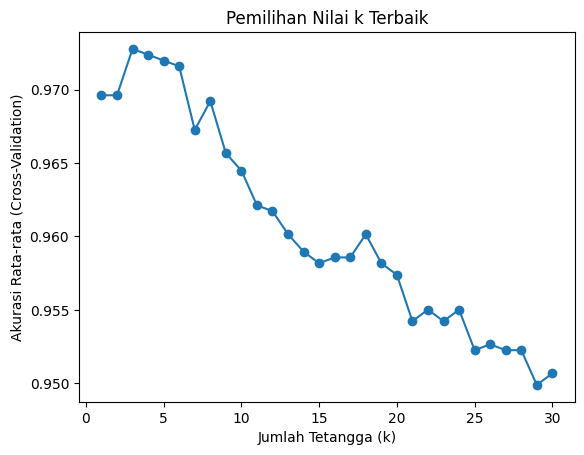

Nilai k terbaik: 3
Akurasi terbaik: 0.9727693710971301


In [ ]:
k_range = range(1, 31)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(knn, X_train, y_train, cv=5).mean())

# Visualisasi hasil
plt.plot(k_range, scores, marker='o')
plt.xlabel('Jumlah Tetangga (k)')
plt.ylabel('Akurasi Rata-rata (Cross-Validation)')
plt.title('Pemilihan Nilai k Terbaik')
plt.show()

best_k = k_range[np.argmax(scores)]
print("Nilai k terbaik:", best_k)
print("Akurasi terbaik:", max(scores))

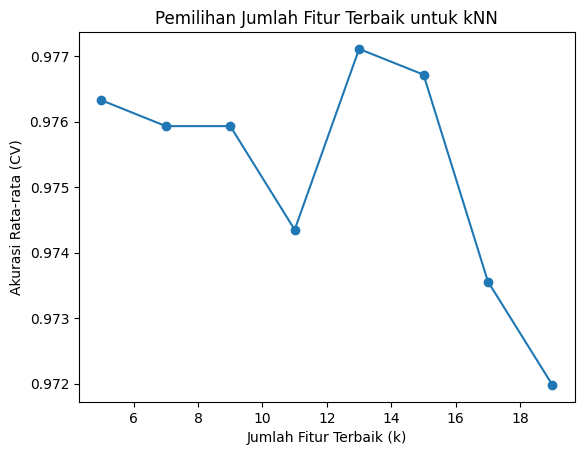

Jumlah fitur optimal: 13
Akurasi tertinggi: 0.9771101807891105


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Uji beberapa jumlah fitur untuk menemukan yang paling optimal
feature_nums = range(5, X.shape[1]+1, 2)
scores_feat = []

for n in feature_nums:
    selector = SelectKBest(score_func=f_classif, k=n)
    X_new = selector.fit_transform(X_train, y_train)

    knn = KNeighborsClassifier(n_neighbors=best_k)
    score = cross_val_score(knn, X_new, y_train, cv=5).mean()
    scores_feat.append(score)

# Visualisasi performa berdasarkan jumlah fitur
plt.plot(feature_nums, scores_feat, marker='o')
plt.xlabel('Jumlah Fitur Terbaik (k)')
plt.ylabel('Akurasi Rata-rata (CV)')
plt.title('Pemilihan Jumlah Fitur Terbaik untuk kNN')
plt.show()

best_features_num = feature_nums[np.argmax(scores_feat)]
print("Jumlah fitur optimal:", best_features_num)
print("Akurasi tertinggi:", max(scores_feat))

Fitur terbaik berdasarkan SelectKBest:
Index(['meanfreq', 'sd', 'median', 'Q25', 'IQR', 'sp.ent', 'sfm', 'centroid',
       'meanfun', 'meandom', 'mindom', 'maxdom', 'dfrange'],
      dtype='object')
Akurasi: 0.9716088328075709

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       317
           1       0.96      0.98      0.97       317

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



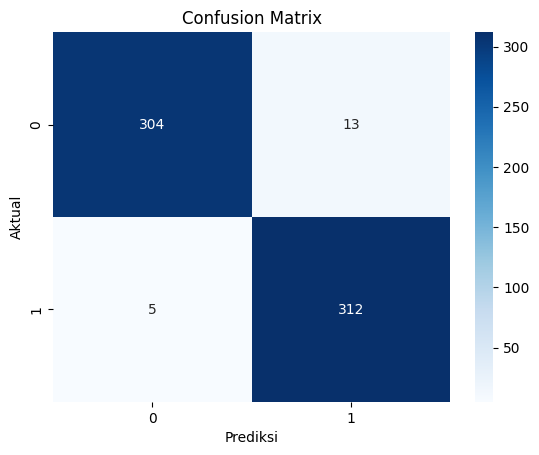

In [ ]:
# Gunakan jumlah fitur terbaik
selector = SelectKBest(score_func=f_classif, k=best_features_num)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]
print("Fitur terbaik berdasarkan SelectKBest:")
print(selected_features)

# Latih ulang model dengan fitur terbaik
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train_sel, y_train)
y_pred = model.predict(X_test_sel)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()